In [1]:
import os
from sklearn.metrics import roc_curve, auc, log_loss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from torch.utils.data import TensorDataset
from torcheval.metrics.functional import binary_accuracy ,binary_auroc, binary_confusion_matrix
from src.experiments.utils.load_folktables import load_folktables_torch

In [2]:
def one_sided_loss_constr(loss, net, c_data):
    w_inputs, w_labels = c_data[0]
    b_inputs, b_labels = c_data[1]
    w_outs = net(w_inputs)
    w_loss = loss(w_outs, w_labels.unsqueeze(1))
    b_outs = net(b_inputs)
    b_loss = loss(b_outs, b_labels.unsqueeze(1))

    return w_loss - b_loss

In [3]:
TASK = 'income'
STATE = 'OK'
LOSS_BOUND=0.005

In [4]:
X_train, y_train, [w_idx_train, nw_idx_train], X_test, y_test, [w_idx_test, nw_idx_test] = load_folktables_torch(
        TASK, state=STATE, random_state=42, make_unbalanced = False
    )

sensitive_value_0 = 'white'
sensitive_value_1 = 'non-white'

In [5]:
X_train_tensor = tensor(X_train, dtype=torch.float)
y_train_tensor = tensor(y_train, dtype=torch.float)
    
X_test_tensor = tensor(X_test, dtype=torch.float)
y_test_tensor = tensor(y_test, dtype=torch.float)
    
X_train_w = X_train_tensor[w_idx_train]
y_train_w = y_train_tensor[w_idx_train]
X_train_nw = X_train_tensor[nw_idx_train]
y_train_nw = y_train_tensor[nw_idx_train]
    
X_test_w = X_test_tensor[w_idx_test]
y_test_w = y_test_tensor[w_idx_test]
X_test_nw = X_test_tensor[nw_idx_test]
y_test_nw = y_test_tensor[nw_idx_test]


In [6]:
class SimpleNet(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_shape),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = SimpleNet(X_test.shape[1], 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

train_ds = TensorDataset(X_train_tensor,y_train_tensor)
train_l = torch.utils.data.DataLoader(train_ds, batch_size=8)

history = {'c_train': [], 'c_test': []}

for i, (inputs, labels) in enumerate(train_l):
    model.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs.T[0], labels)
    loss.backward()
    optimizer.step()
    with torch.inference_mode():
        outs = model(X_test_tensor)
        loss = loss_fn(outs, y_test_tensor.unsqueeze(1)).detach().cpu().numpy()
        
        c1_train = one_sided_loss_constr(loss_fn, model, [(X_train_w, y_train_w), (X_train_nw, y_train_nw)]).detach().cpu().numpy()
        c2_train = -c1_train
        
        c1_test = one_sided_loss_constr(loss_fn, model, [(X_test_w, y_test_w), (X_test_nw, y_test_nw)]).detach().cpu().numpy()
        c2_test = -c1_test
        
        history['c_train'].append(c1_train)
        history['c_test'].append(c1_test)
    print(i, end='\r')

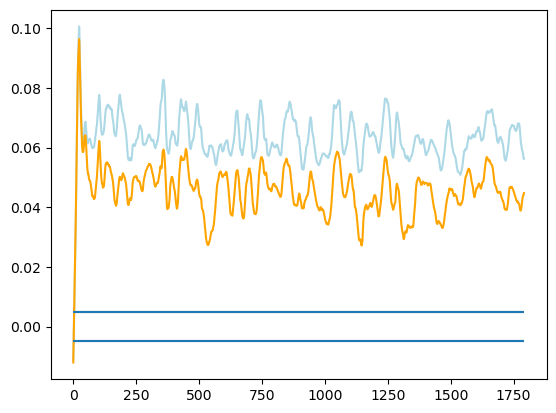

In [9]:
def pl(data,c):
    plt.plot(data, c=c)
    plt.hlines(xmin=0,xmax=len(data), y=LOSS_BOUND)
    plt.hlines(xmin=0,xmax=len(data), y=-LOSS_BOUND)

pl(history['c_train'], 'lightblue')
pl(history['c_test'], 'orange')

In [12]:
from fairret.statistic import TruePositiveRate

statistic = TruePositiveRate()

preds = torch.concat([model(X_test_w), model(X_test_nw)])
pred = torch.sigmoid(preds)
sens = torch.concat([torch.tensor([[1.,0.]]*len(X_test_w)), torch.tensor([[0.,1.]]*len(X_test_nw))])
label = torch.concat([y_test_w, y_test_nw])

stat_per_group = statistic(pred, sens, label.unsqueeze(1))
absolute_diff = torch.abs(stat_per_group[0] - stat_per_group[1])

In [13]:
print(stat_per_group)
print(absolute_diff)

tensor([0.5403, 0.4747], grad_fn=<IndexPutBackward0>)
tensor(0.0657, grad_fn=<AbsBackward0>)
